In [3]:
!pip install PyGAD

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


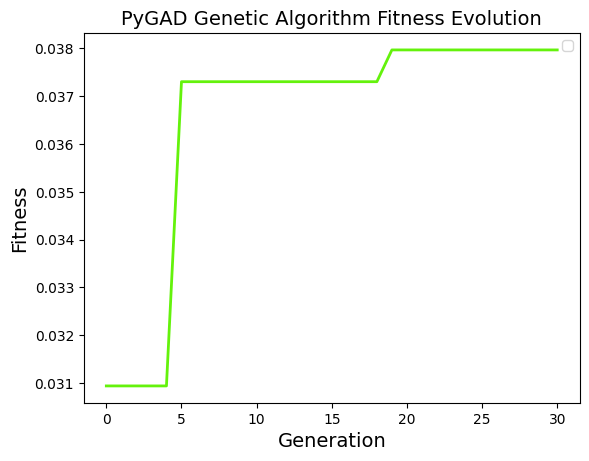

Best Solution Fitness (Correlation with RTP Score): 0.037968697772091685
Best Solution (Feature Weights):
 [0.43104597 0.73321364 0.24511999 0.82715287 0.66334939 0.27103493
 0.32313551 0.1316983  0.81265525 0.25308023 0.86985426 0.13681658
 0.48651638 0.92579157 0.41954302 0.84802933 0.35341009 0.70705792
 0.21395211 0.33333163 0.7009497  0.91145726 0.45457237 0.04675725
 0.28131958 0.02060272 0.20104463 0.03115286 0.54314469 0.14842156
 0.77599549 0.87598542 0.233272   0.44233897 0.88052865 0.91803946
 0.08698976 0.69211587 0.18535801 0.83027953 0.12453907 0.44520198
 0.46910745 0.0511865  0.73592725 0.61281782 0.33568166 0.82775567
 0.57640389 0.28022916 0.51893599]


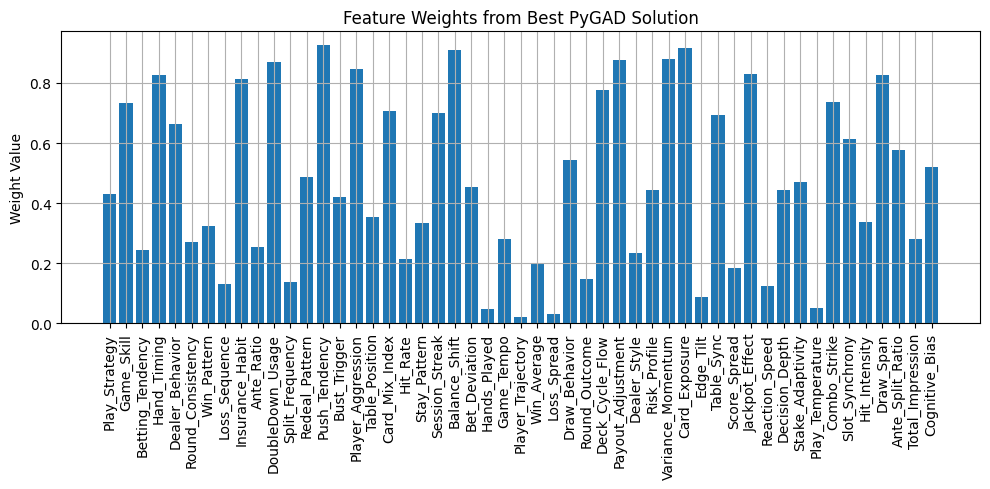

In [4]:
# Genetic Algorithm to Optimize RTP Score using PyGAD (No RL Version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pygad

# Load the synthetic dataset
df = pd.read_csv('/content/sample_data/synthetic_data.csv')

# Separate features and target
features = [col for col in df.columns if col != 'RTP_Score']
X = df[features]
y = df['RTP_Score']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    weighted_sum = X_scaled.dot(solution)
    score = np.corrcoef(weighted_sum, y)[0, 1]
    return score if not np.isnan(score) else 0

# PyGAD GA configuration
ga_instance = pygad.GA(
    num_generations=30,
    num_parents_mating=10,
    fitness_func=fitness_func,
    sol_per_pop=20,
    num_genes=X.shape[1],
    mutation_percent_genes=20,
    mutation_type="random",
    crossover_type="single_point",
    gene_space={'low': 0.0, 'high': 1.0},
    parent_selection_type="rank"
)

# Run the GA
ga_instance.run()

# Extract fitness evolution
ga_instance.plot_fitness(title="PyGAD Genetic Algorithm Fitness Evolution", linewidth=2)

# Best solution details
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Best Solution Fitness (Correlation with RTP Score):", solution_fitness)
print("Best Solution (Feature Weights):\n", solution)

# Optional: Weighted feature importance plot
plt.figure(figsize=(10, 5))
plt.bar(features, solution)
plt.xticks(rotation=90)
plt.title("Feature Weights from Best PyGAD Solution")
plt.ylabel("Weight Value")
plt.tight_layout()
plt.grid(True)
plt.show()

Generation 1 - Best Fitness (Simulated RTP Corr): 0.0455
Generation 2 - Best Fitness (Simulated RTP Corr): 0.0437
Generation 3 - Best Fitness (Simulated RTP Corr): 0.0477
Generation 4 - Best Fitness (Simulated RTP Corr): 0.0524
Generation 5 - Best Fitness (Simulated RTP Corr): 0.0513
Generation 6 - Best Fitness (Simulated RTP Corr): 0.0519
Generation 7 - Best Fitness (Simulated RTP Corr): 0.0566
Generation 8 - Best Fitness (Simulated RTP Corr): 0.0555
Generation 9 - Best Fitness (Simulated RTP Corr): 0.0588
Generation 10 - Best Fitness (Simulated RTP Corr): 0.0640
Generation 11 - Best Fitness (Simulated RTP Corr): 0.0609
Generation 12 - Best Fitness (Simulated RTP Corr): 0.0594
Generation 13 - Best Fitness (Simulated RTP Corr): 0.0604
Generation 14 - Best Fitness (Simulated RTP Corr): 0.0607
Generation 15 - Best Fitness (Simulated RTP Corr): 0.0617
Generation 16 - Best Fitness (Simulated RTP Corr): 0.0677
Generation 17 - Best Fitness (Simulated RTP Corr): 0.0654
Generation 18 - Best Fi

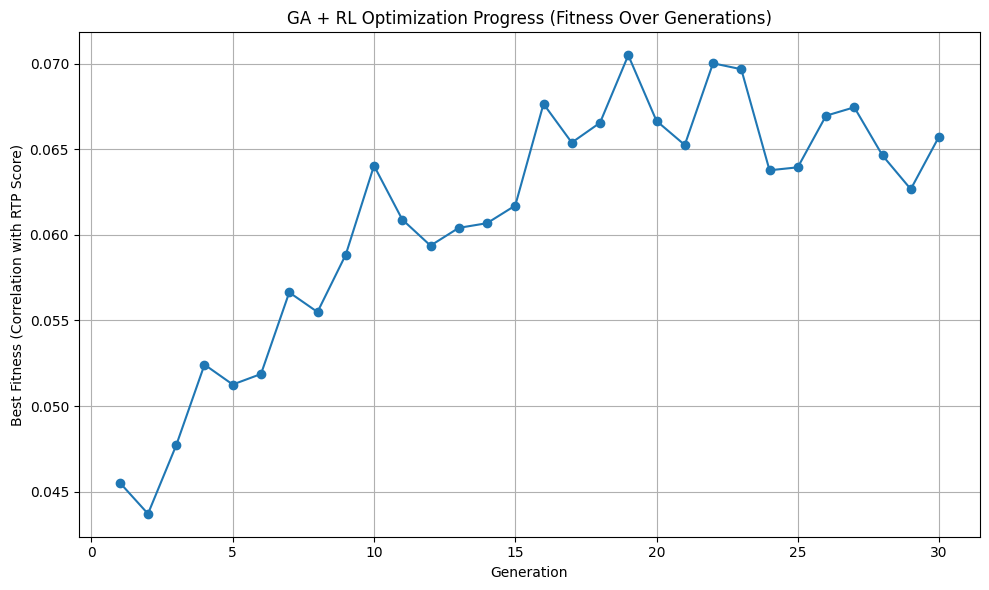

In [7]:
# Genetic Algorithm using PyGAD + RL (MAB) to Optimize RTP Score on Synthetic Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pygad
import random

# Load the synthetic dataset
df = pd.read_csv('/content/sample_data/synthetic_data.csv')

# Automatically detect feature columns (exclude RTP_Score)
strategy_features = [col for col in df.columns if col != 'RTP_Score']

# Normalize the selected features
scaler = MinMaxScaler()
df[strategy_features] = scaler.fit_transform(df[strategy_features])

# Define fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weighted_sum = df[strategy_features].values.dot(weights)
    simulated_rtp = np.corrcoef(weighted_sum, df['RTP_Score'])[0, 1]
    return simulated_rtp if not np.isnan(simulated_rtp) else 0

# RL Agent (Multi-Armed Bandit using UCB for selecting mutation operator type)
class MABAgent:
    def __init__(self, num_arms):
        self.counts = [0] * num_arms
        self.values = [0.0] * num_arms
        self.total_count = 0

    def select_arm(self):
        if self.total_count < len(self.counts):
            return self.total_count
        ucb_values = [v + np.sqrt(2 * np.log(self.total_count + 1) / (c + 1e-5))
                      for v, c in zip(self.values, self.counts)]
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.total_count += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) * value + reward) / n

# Mutation strategy definitions
def normal_mutation(solution, mutation_rate=0.2):
    return np.clip([gene + np.random.normal(0, 0.1) if random.random() < mutation_rate else gene for gene in solution], 0, 1)

def uniform_mutation(solution, mutation_rate=0.2):
    return np.clip([np.random.rand() if random.random() < mutation_rate else gene for gene in solution], 0, 1)

# Initialize GA + RL loop manually
generations = 30
population_size = 20
num_parents = 10
chromosome_length = len(strategy_features)
mutation_strategies = ['normal', 'uniform']
mutation_functions = [normal_mutation, uniform_mutation]
agent = MABAgent(num_arms=len(mutation_strategies))
best_fitness_over_time = []

# Initialize population
population = [np.random.rand(chromosome_length) for _ in range(population_size)]

for gen in range(generations):
    fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(population)]
    best_fitness = max(fitnesses)
    best_fitness_over_time.append(best_fitness)

    print(f"Generation {gen+1} - Best Fitness (Simulated RTP Corr): {best_fitness:.4f}")

    # Select mutation strategy via RL (MAB)
    selected_arm = agent.select_arm()
    mutation_func = mutation_functions[selected_arm]

    # Selection
    parents = np.array(population)[np.argsort(fitnesses)][-num_parents:]

    # Generate new population
    new_population = []
    for _ in range(population_size):
        p1, p2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, chromosome_length - 1)
        child = np.concatenate([p1[:crossover_point], p2[crossover_point:]])
        child = mutation_func(child)
        new_population.append(np.clip(child, 0, 1))

    new_fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(new_population)]
    reward = max(new_fitnesses) - best_fitness
    agent.update(selected_arm, reward)
    population = new_population

# Plot fitness progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, generations + 1), best_fitness_over_time, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Correlation with RTP Score)")
plt.title("GA + RL Optimization Progress (Fitness Over Generations)")
plt.grid(True)
plt.tight_layout()
plt.show()

Generation 1 - Best Fitness (Simulated RTP Corr): 0.0308
Generation 2 - Best Fitness (Simulated RTP Corr): 0.0329
Generation 3 - Best Fitness (Simulated RTP Corr): 0.0369
Generation 4 - Best Fitness (Simulated RTP Corr): 0.0453
Generation 5 - Best Fitness (Simulated RTP Corr): 0.0471
Generation 6 - Best Fitness (Simulated RTP Corr): 0.0592
Generation 7 - Best Fitness (Simulated RTP Corr): 0.0619
Generation 8 - Best Fitness (Simulated RTP Corr): 0.0590
Generation 9 - Best Fitness (Simulated RTP Corr): 0.0598
Generation 10 - Best Fitness (Simulated RTP Corr): 0.0597
Generation 11 - Best Fitness (Simulated RTP Corr): 0.0662
Generation 12 - Best Fitness (Simulated RTP Corr): 0.0654
Generation 13 - Best Fitness (Simulated RTP Corr): 0.0638
Generation 14 - Best Fitness (Simulated RTP Corr): 0.0665
Generation 15 - Best Fitness (Simulated RTP Corr): 0.0733
Generation 16 - Best Fitness (Simulated RTP Corr): 0.0649
Generation 17 - Best Fitness (Simulated RTP Corr): 0.0713
Generation 18 - Best Fi

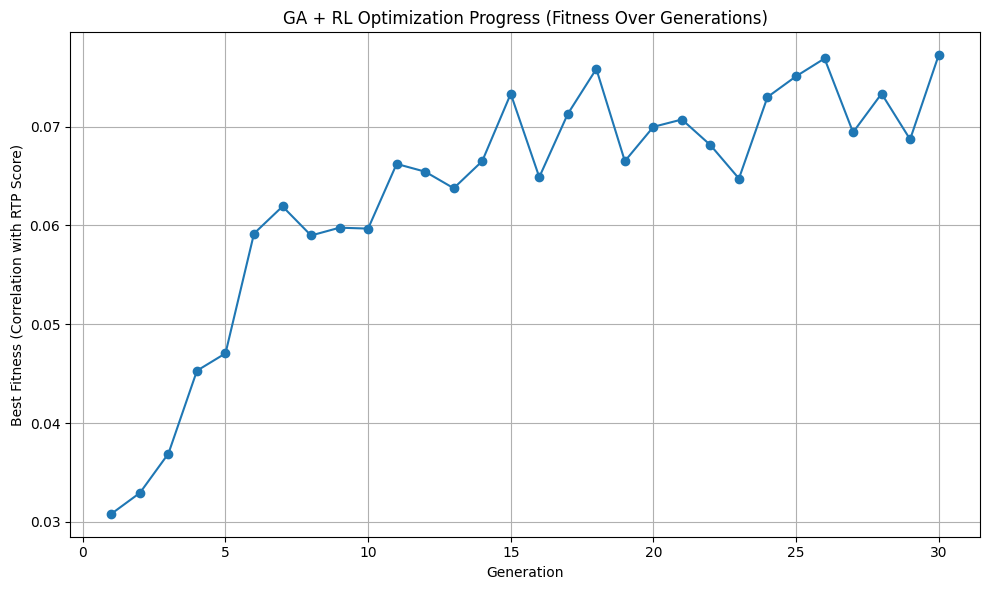

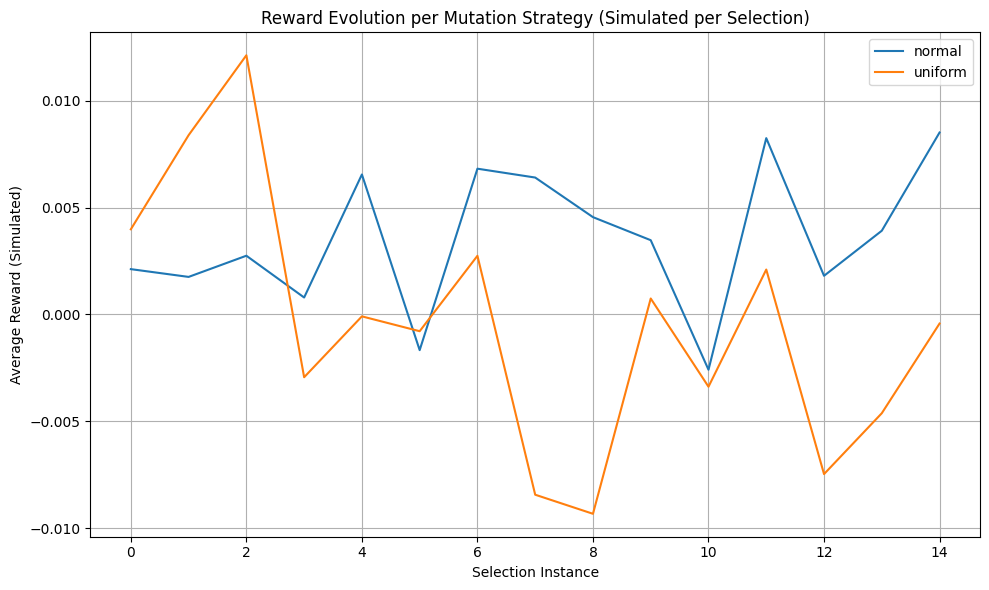

In [10]:
# Genetic Algorithm using PyGAD + RL (MAB) to Optimize RTP Score on Synthetic Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pygad
import random

# Load the synthetic dataset
df = pd.read_csv('/content/sample_data/synthetic_data.csv')

# Automatically detect feature columns (exclude RTP_Score)
strategy_features = [col for col in df.columns if col != 'RTP_Score']

# Normalize the selected features
scaler = MinMaxScaler()
df[strategy_features] = scaler.fit_transform(df[strategy_features])

# Define fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weighted_sum = df[strategy_features].values.dot(weights)
    simulated_rtp = np.corrcoef(weighted_sum, df['RTP_Score'])[0, 1]
    return simulated_rtp if not np.isnan(simulated_rtp) else 0

# RL Agent (Multi-Armed Bandit using UCB for selecting mutation operator type)
class MABAgent:
    def __init__(self, num_arms):
        self.counts = [0] * num_arms
        self.values = [0.0] * num_arms
        self.total_count = 0
        self.reward_history = [[] for _ in range(num_arms)]

    def select_arm(self):
        if self.total_count < len(self.counts):
            return self.total_count
        ucb_values = [v + np.sqrt(2 * np.log(self.total_count + 1) / (c + 1e-5))
                      for v, c in zip(self.values, self.counts)]
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.total_count += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) * value + reward) / n
        self.reward_history[arm].append(reward)

# Mutation strategy definitions
def normal_mutation(solution, mutation_rate=0.2):
    return np.clip([gene + np.random.normal(0, 0.1) if random.random() < mutation_rate else gene for gene in solution], 0, 1)

def uniform_mutation(solution, mutation_rate=0.2):
    return np.clip([np.random.rand() if random.random() < mutation_rate else gene for gene in solution], 0, 1)

# Initialize GA + RL loop manually
generations = 30
population_size = 20
num_parents = 10
chromosome_length = len(strategy_features)
mutation_strategies = ['normal', 'uniform']
mutation_functions = [normal_mutation, uniform_mutation]
agent = MABAgent(num_arms=len(mutation_strategies))
best_fitness_over_time = []

# Initialize population
population = [np.random.rand(chromosome_length) for _ in range(population_size)]

for gen in range(generations):
    fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(population)]
    best_fitness = max(fitnesses)
    best_fitness_over_time.append(best_fitness)

    print(f"Generation {gen+1} - Best Fitness (Simulated RTP Corr): {best_fitness:.4f}")

    # Select mutation strategy via RL (MAB)
    selected_arm = agent.select_arm()
    mutation_func = mutation_functions[selected_arm]

    # Selection
    parents = np.array(population)[np.argsort(fitnesses)][-num_parents:]

    # Generate new population
    new_population = []
    for _ in range(population_size):
        p1, p2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, chromosome_length - 1)
        child = np.concatenate([p1[:crossover_point], p2[crossover_point:]])
        child = mutation_func(child)
        new_population.append(np.clip(child, 0, 1))

    new_fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(new_population)]
    reward = max(new_fitnesses) - best_fitness
    agent.update(selected_arm, reward)
    population = new_population

# Plot fitness progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, generations + 1), best_fitness_over_time, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Correlation with RTP Score)")
plt.title("GA + RL Optimization Progress (Fitness Over Generations)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Reward Evolution per Mutation Strategy
plt.figure(figsize=(10, 6))
for i, strategy in enumerate(mutation_strategies):
    plt.plot(agent.reward_history[i], label=strategy)
plt.title("Reward Evolution per Mutation Strategy (Simulated per Selection)")
plt.xlabel("Selection Instance")
plt.ylabel("Average Reward (Simulated)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


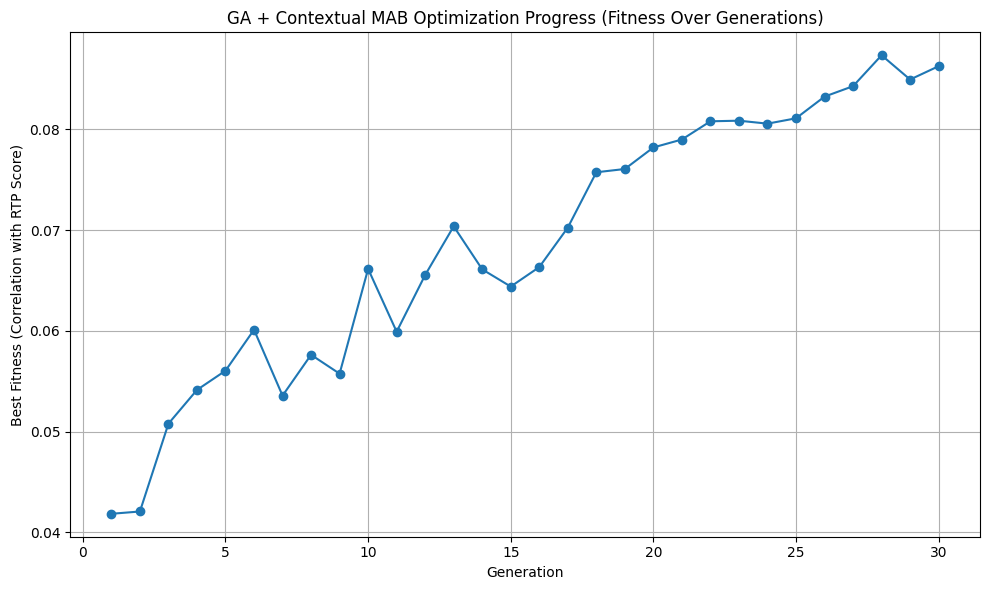

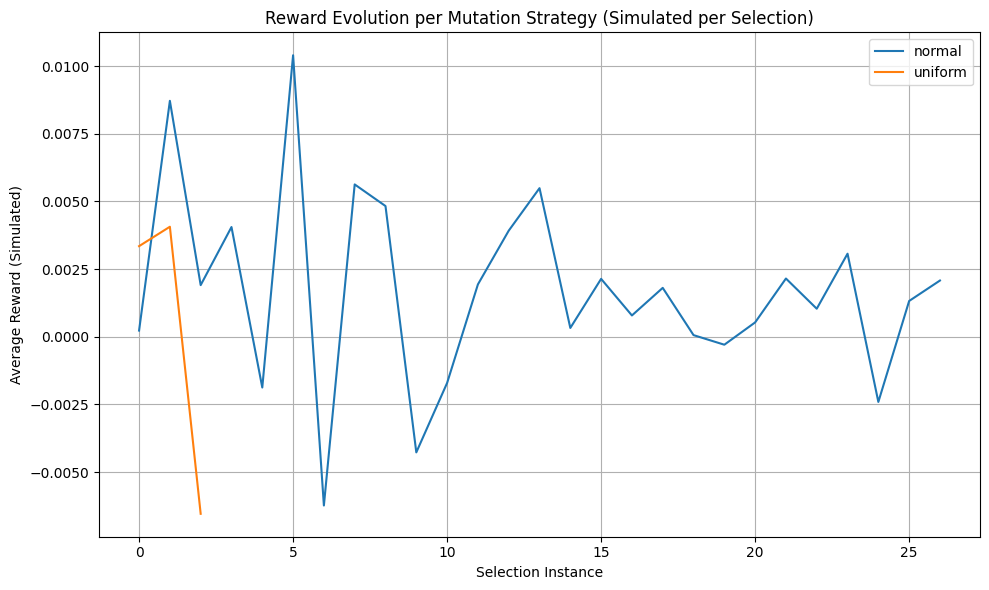

In [11]:
# Genetic Algorithm using PyGAD + RL (Contextual MAB) to Optimize RTP Score on Synthetic Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import pygad
import random

# Load the synthetic dataset
df = pd.read_csv('/content/sample_data/synthetic_data.csv')

# Automatically detect feature columns (exclude RTP_Score)
strategy_features = [col for col in df.columns if col != 'RTP_Score']

# Normalize the selected features
scaler = MinMaxScaler()
df[strategy_features] = scaler.fit_transform(df[strategy_features])

# Define fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weighted_sum = df[strategy_features].values.dot(weights)
    simulated_rtp = np.corrcoef(weighted_sum, df['RTP_Score'])[0, 1]
    return simulated_rtp if not np.isnan(simulated_rtp) else 0

# Contextual Multi-Armed Bandit Agent using Ridge Regression
class CMABAgent:
    def __init__(self, num_arms, context_dim):
        self.models = [Ridge(alpha=1.0) for _ in range(num_arms)]
        self.contexts = [[] for _ in range(num_arms)]
        self.rewards = [[] for _ in range(num_arms)]
        self.num_arms = num_arms
        self.context_dim = context_dim
        self.reward_history = [[] for _ in range(num_arms)]

    def select_arm(self, context):
        preds = []
        for i in range(self.num_arms):
            if len(self.contexts[i]) < self.context_dim:
                preds.append(np.random.rand())
            else:
                preds.append(self.models[i].predict(context.reshape(1, -1))[0])
        return np.argmax(preds)

    def update(self, arm, context, reward):
        self.contexts[arm].append(context)
        self.rewards[arm].append(reward)
        self.reward_history[arm].append(reward)
        if len(self.contexts[arm]) >= self.context_dim:
            X = np.array(self.contexts[arm])
            y = np.array(self.rewards[arm])
            self.models[arm].fit(X, y)

# Mutation strategy definitions
def normal_mutation(solution, mutation_rate=0.2):
    return np.clip([gene + np.random.normal(0, 0.1) if random.random() < mutation_rate else gene for gene in solution], 0, 1)

def uniform_mutation(solution, mutation_rate=0.2):
    return np.clip([np.random.rand() if random.random() < mutation_rate else gene for gene in solution], 0, 1)

# Initialize GA + Contextual MAB loop
generations = 30
population_size = 20
num_parents = 10
chromosome_length = len(strategy_features)
mutation_strategies = ['normal', 'uniform']
mutation_functions = [normal_mutation, uniform_mutation]
agent = CMABAgent(num_arms=len(mutation_strategies), context_dim=3)
best_fitness_over_time = []

# Initialize population
population = [np.random.rand(chromosome_length) for _ in range(population_size)]
prev_avg = 0

for gen in range(generations):
    fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(population)]
    best_fitness = max(fitnesses)
    avg_fitness = np.mean(fitnesses)
    diversity = np.std(fitnesses)
    best_fitness_over_time.append(best_fitness)

    context = np.array([avg_fitness, best_fitness, diversity])
    selected_arm = agent.select_arm(context)
    mutation_func = mutation_functions[selected_arm]

    # Selection
    parents = np.array(population)[np.argsort(fitnesses)][-num_parents:]

    # Generate new population
    new_population = []
    for _ in range(population_size):
        p1, p2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, chromosome_length - 1)
        child = np.concatenate([p1[:crossover_point], p2[crossover_point:]])
        child = mutation_func(child)
        new_population.append(np.clip(child, 0, 1))

    new_fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(new_population)]
    reward = max(new_fitnesses) - best_fitness
    agent.update(selected_arm, context, reward)
    population = new_population
    prev_avg = avg_fitness

# Plot fitness progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, generations + 1), best_fitness_over_time, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Correlation with RTP Score)")
plt.title("GA + Contextual MAB Optimization Progress (Fitness Over Generations)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Reward Evolution per Mutation Strategy
plt.figure(figsize=(10, 6))
for i, strategy in enumerate(mutation_strategies):
    plt.plot(agent.reward_history[i], label=strategy)
plt.title("Reward Evolution per Mutation Strategy (Simulated per Selection)")
plt.xlabel("Selection Instance")
plt.ylabel("Average Reward (Simulated)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


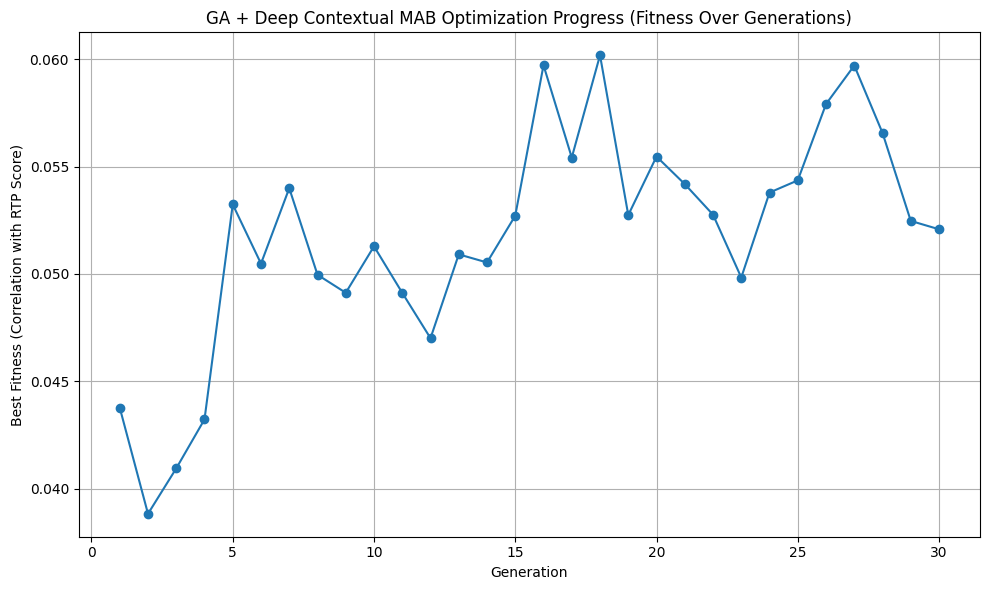

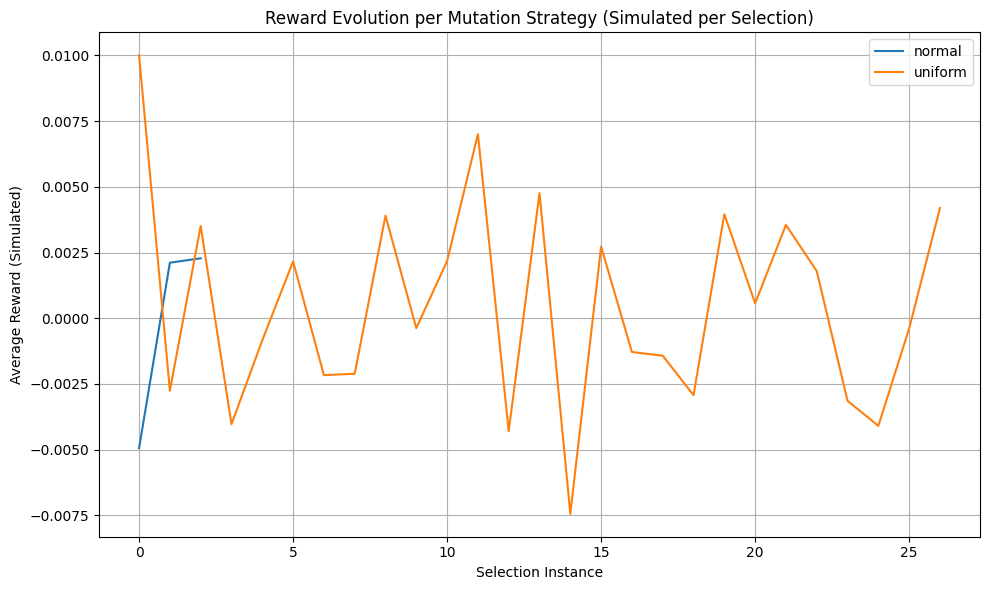

In [12]:
# Genetic Algorithm using PyGAD + RL (Deep Contextual MAB) to Optimize RTP Score on Synthetic Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import pygad
import random

# Load the synthetic dataset
df = pd.read_csv('/content/sample_data/synthetic_data.csv')

# Automatically detect feature columns (exclude RTP_Score)
strategy_features = [col for col in df.columns if col != 'RTP_Score']

# Normalize the selected features
scaler = MinMaxScaler()
df[strategy_features] = scaler.fit_transform(df[strategy_features])

# Define fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weighted_sum = df[strategy_features].values.dot(weights)
    simulated_rtp = np.corrcoef(weighted_sum, df['RTP_Score'])[0, 1]
    return simulated_rtp if not np.isnan(simulated_rtp) else 0

# Deep Contextual Multi-Armed Bandit Agent
class DeepCMABAgent:
    def __init__(self, num_arms, context_dim):
        self.models = [self._build_model(context_dim) for _ in range(num_arms)]
        self.contexts = [[] for _ in range(num_arms)]
        self.rewards = [[] for _ in range(num_arms)]
        self.num_arms = num_arms
        self.context_dim = context_dim
        self.reward_history = [[] for _ in range(num_arms)]

    def _build_model(self, input_dim):
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(8, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
        return model

    def select_arm(self, context):
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        preds = []
        for model in self.models:
            preds.append(model.predict(context.reshape(1, -1), verbose=0)[0][0])
        return np.argmax(preds)

    def update(self, arm, context, reward):
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        self.contexts[arm].append(context)
        self.rewards[arm].append(reward)
        self.reward_history[arm].append(reward)
        if len(self.contexts[arm]) >= self.context_dim:
            X = np.array(self.contexts[arm])
            y = np.array(self.rewards[arm])
            self.models[arm].fit(X, y, epochs=10, verbose=0)

# Mutation strategy definitions
def normal_mutation(solution, mutation_rate=0.2):
    return np.clip([gene + np.random.normal(0, 0.1) if random.random() < mutation_rate else gene for gene in solution], 0, 1)

def uniform_mutation(solution, mutation_rate=0.2):
    return np.clip([np.random.rand() if random.random() < mutation_rate else gene for gene in solution], 0, 1)

# Initialize GA + Deep Contextual MAB loop
generations = 30
population_size = 20
num_parents = 10
chromosome_length = len(strategy_features)
mutation_strategies = ['normal', 'uniform']
mutation_functions = [normal_mutation, uniform_mutation]
agent = DeepCMABAgent(num_arms=len(mutation_strategies), context_dim=3)
best_fitness_over_time = []

# Initialize population
population = [np.random.rand(chromosome_length) for _ in range(population_size)]
prev_avg = 0

for gen in range(generations):
    fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(population)]
    best_fitness = max(fitnesses)
    avg_fitness = np.mean(fitnesses)
    diversity = np.std(fitnesses)
    best_fitness_over_time.append(best_fitness)

    context = np.array([avg_fitness, best_fitness, diversity])
    selected_arm = agent.select_arm(context)
    mutation_func = mutation_functions[selected_arm]

    # Selection
    parents = np.array(population)[np.argsort(fitnesses)][-num_parents:]

    # Generate new population
    new_population = []
    for _ in range(population_size):
        p1, p2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, chromosome_length - 1)
        child = np.concatenate([p1[:crossover_point], p2[crossover_point:]])
        child = mutation_func(child)
        new_population.append(np.clip(child, 0, 1))

    new_fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(new_population)]
    reward = max(new_fitnesses) - best_fitness
    agent.update(selected_arm, context, reward)
    population = new_population
    prev_avg = avg_fitness

# Plot fitness progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, generations + 1), best_fitness_over_time, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Correlation with RTP Score)")
plt.title("GA + Deep Contextual MAB Optimization Progress (Fitness Over Generations)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Reward Evolution per Mutation Strategy
plt.figure(figsize=(10, 6))
for i, strategy in enumerate(mutation_strategies):
    plt.plot(agent.reward_history[i], label=strategy)
plt.title("Reward Evolution per Mutation Strategy (Simulated per Selection)")
plt.xlabel("Selection Instance")
plt.ylabel("Average Reward (Simulated)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


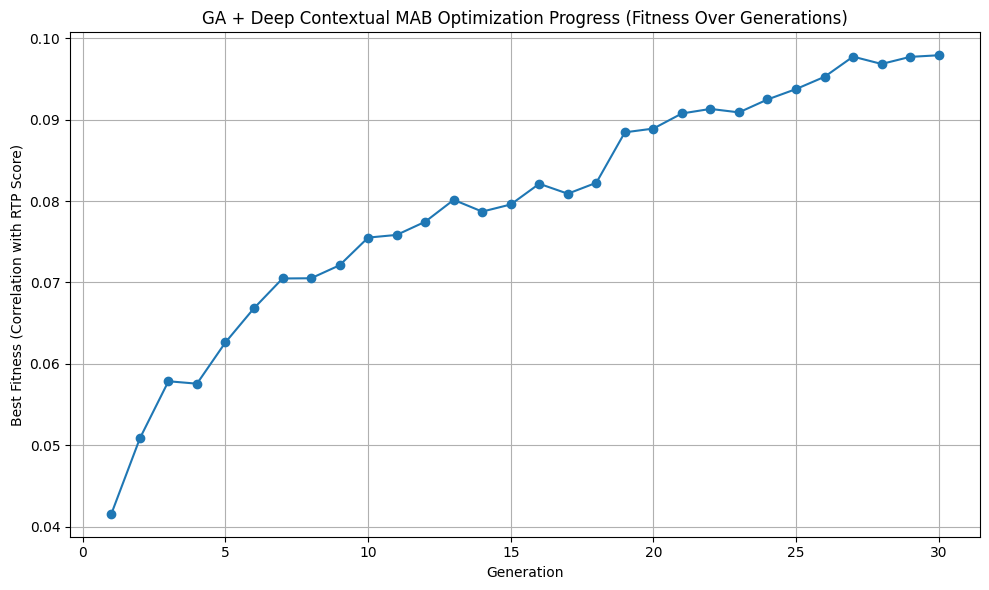

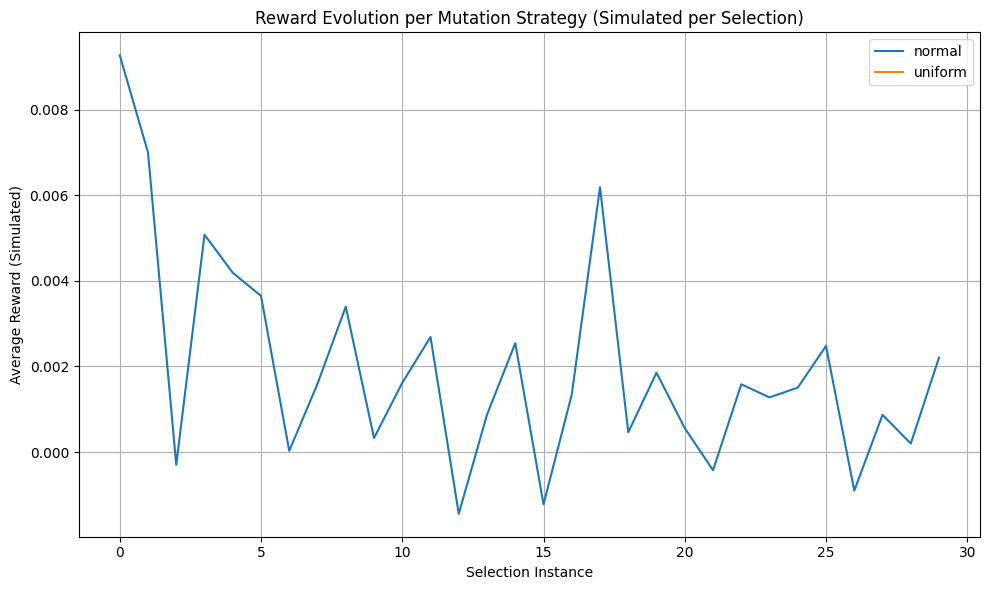

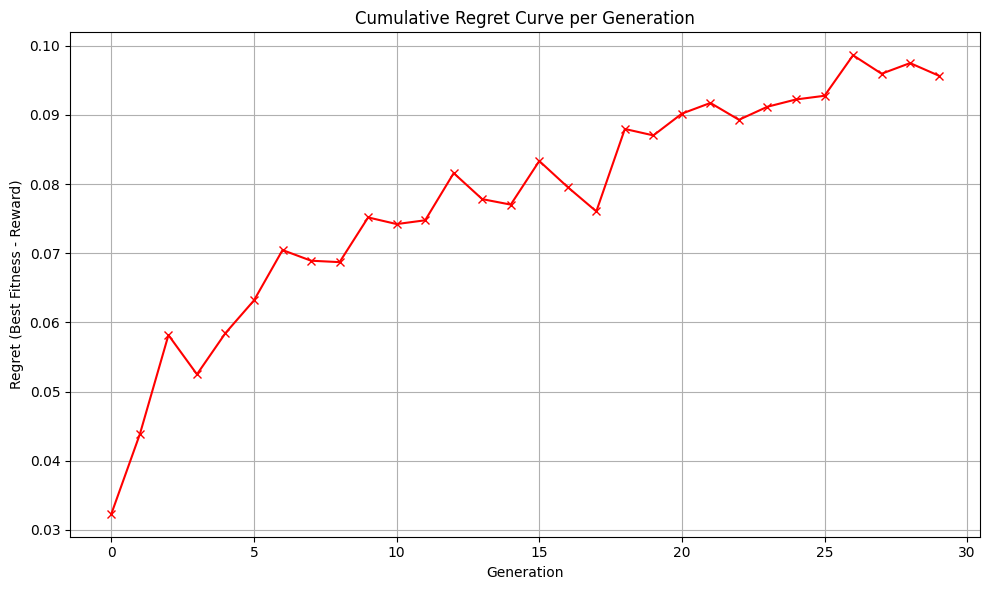

In [13]:
# Genetic Algorithm using PyGAD + RL (Deep Contextual MAB) to Optimize RTP Score on Synthetic Data with Regret Tracking
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import pygad
import random

# Load the synthetic dataset
df = pd.read_csv('/content/sample_data/synthetic_data.csv')

# Automatically detect feature columns (exclude RTP_Score)
strategy_features = [col for col in df.columns if col != 'RTP_Score']

# Normalize the selected features
scaler = MinMaxScaler()
df[strategy_features] = scaler.fit_transform(df[strategy_features])

# Define fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weighted_sum = df[strategy_features].values.dot(weights)
    simulated_rtp = np.corrcoef(weighted_sum, df['RTP_Score'])[0, 1]
    return simulated_rtp if not np.isnan(simulated_rtp) else 0

# Deep Contextual Multi-Armed Bandit Agent
class DeepCMABAgent:
    def __init__(self, num_arms, context_dim):
        self.models = [self._build_model(context_dim) for _ in range(num_arms)]
        self.contexts = [[] for _ in range(num_arms)]
        self.rewards = [[] for _ in range(num_arms)]
        self.num_arms = num_arms
        self.context_dim = context_dim
        self.reward_history = [[] for _ in range(num_arms)]
        self.selection_counts = [0] * num_arms
        self.cumulative_rewards = [0.0] * num_arms

    def _build_model(self, input_dim):
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(8, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
        return model

    def select_arm(self, context):
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        preds = []
        for model in self.models:
            preds.append(model.predict(context.reshape(1, -1), verbose=0)[0][0])
        return np.argmax(preds)

    def update(self, arm, context, reward):
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        self.contexts[arm].append(context)
        self.rewards[arm].append(reward)
        self.reward_history[arm].append(reward)
        self.selection_counts[arm] += 1
        self.cumulative_rewards[arm] += reward
        if len(self.contexts[arm]) >= self.context_dim:
            X = np.array(self.contexts[arm])
            y = np.array(self.rewards[arm])
            self.models[arm].fit(X, y, epochs=10, verbose=0)

# Mutation strategy definitions
def normal_mutation(solution, mutation_rate=0.2):
    return np.clip([gene + np.random.normal(0, 0.1) if random.random() < mutation_rate else gene for gene in solution], 0, 1)

def uniform_mutation(solution, mutation_rate=0.2):
    return np.clip([np.random.rand() if random.random() < mutation_rate else gene for gene in solution], 0, 1)

# Initialize GA + Deep Contextual MAB loop
generations = 30
population_size = 20
num_parents = 10
chromosome_length = len(strategy_features)
mutation_strategies = ['normal', 'uniform']
mutation_functions = [normal_mutation, uniform_mutation]
agent = DeepCMABAgent(num_arms=len(mutation_strategies), context_dim=3)
best_fitness_over_time = []
regret_history = []

# Initialize population
population = [np.random.rand(chromosome_length) for _ in range(population_size)]
prev_avg = 0

for gen in range(generations):
    fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(population)]
    best_fitness = max(fitnesses)
    avg_fitness = np.mean(fitnesses)
    diversity = np.std(fitnesses)
    best_fitness_over_time.append(best_fitness)

    context = np.array([avg_fitness, best_fitness, diversity])
    selected_arm = agent.select_arm(context)
    mutation_func = mutation_functions[selected_arm]

    # Selection
    parents = np.array(population)[np.argsort(fitnesses)][-num_parents:]

    # Generate new population
    new_population = []
    for _ in range(population_size):
        p1, p2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, chromosome_length - 1)
        child = np.concatenate([p1[:crossover_point], p2[crossover_point:]])
        child = mutation_func(child)
        new_population.append(np.clip(child, 0, 1))

    new_fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(new_population)]
    reward = max(new_fitnesses) - best_fitness
    regret = max(best_fitness - reward, 0)
    regret_history.append(regret)
    agent.update(selected_arm, context, reward)
    population = new_population
    prev_avg = avg_fitness

# Plot fitness progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, generations + 1), best_fitness_over_time, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Correlation with RTP Score)")
plt.title("GA + Deep Contextual MAB Optimization Progress (Fitness Over Generations)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Reward Evolution per Mutation Strategy
plt.figure(figsize=(10, 6))
for i, strategy in enumerate(mutation_strategies):
    plt.plot(agent.reward_history[i], label=strategy)
plt.title("Reward Evolution per Mutation Strategy (Simulated per Selection)")
plt.xlabel("Selection Instance")
plt.ylabel("Average Reward (Simulated)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Regret Curve
plt.figure(figsize=(10, 6))
plt.plot(regret_history, marker='x', color='red')
plt.title("Cumulative Regret Curve per Generation")
plt.xlabel("Generation")
plt.ylabel("Regret (Best Fitness - Reward)")
plt.grid(True)
plt.tight_layout()
plt.show()

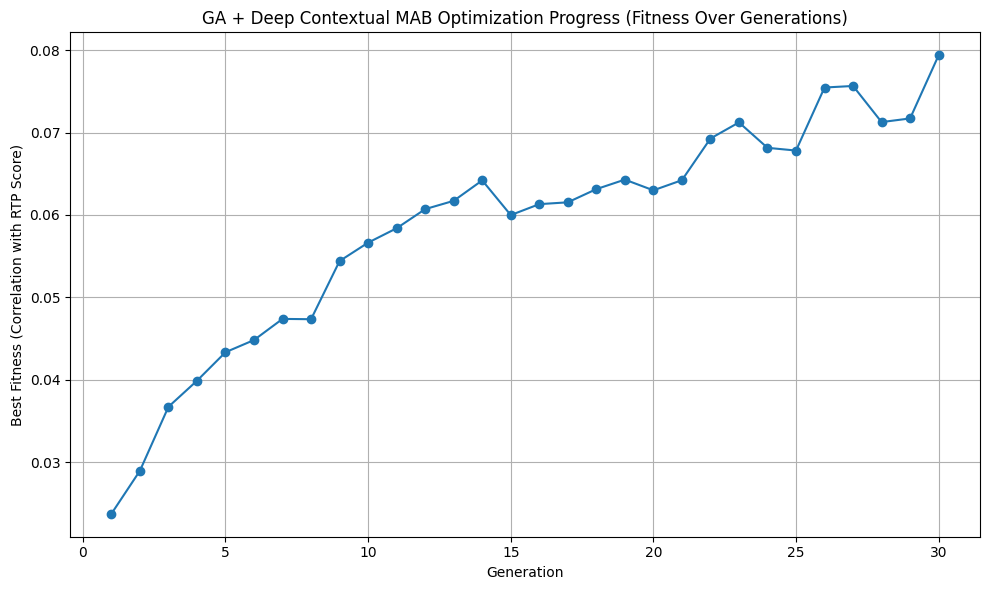

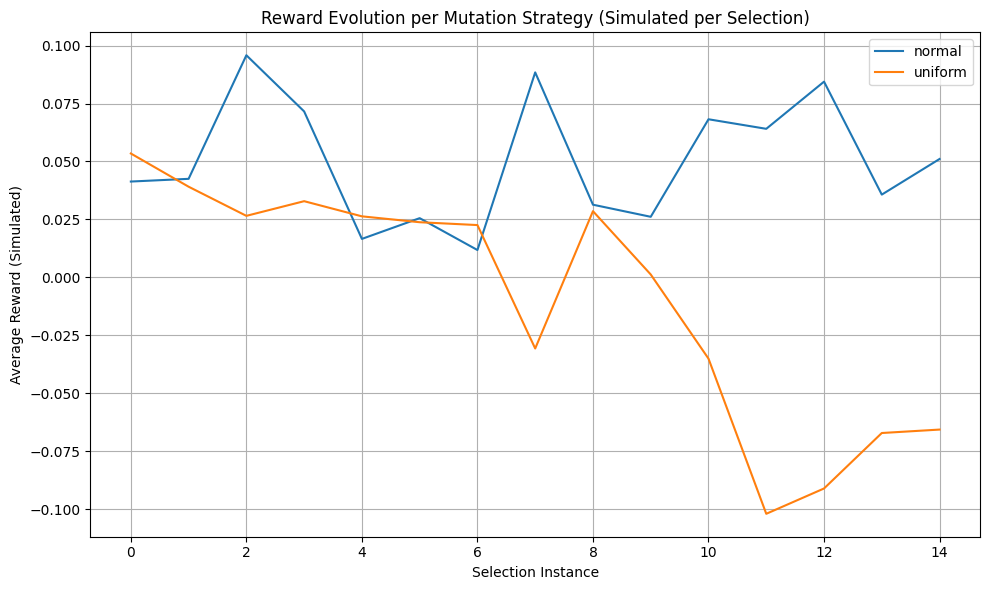

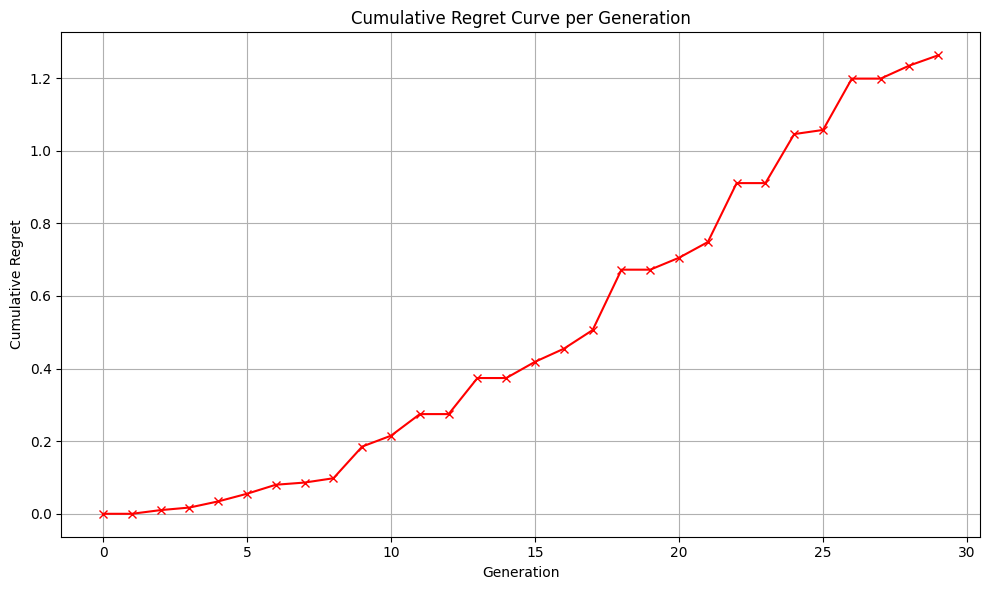

In [14]:
# Genetic Algorithm using PyGAD + RL (Deep Contextual MAB) with Improved Reward Strategy and Regret Tracking
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import pygad
import random

# Load the synthetic dataset
df = pd.read_csv('/content/sample_data/synthetic_data.csv')

# Automatically detect feature columns (exclude RTP_Score)
strategy_features = [col for col in df.columns if col != 'RTP_Score']

# Normalize the selected features
scaler = MinMaxScaler()
df[strategy_features] = scaler.fit_transform(df[strategy_features])

# Define fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weighted_sum = df[strategy_features].values.dot(weights)
    simulated_rtp = np.corrcoef(weighted_sum, df['RTP_Score'])[0, 1]
    return simulated_rtp if not np.isnan(simulated_rtp) else 0

# Deep Contextual Multi-Armed Bandit Agent
class DeepCMABAgent:
    def __init__(self, num_arms, context_dim):
        self.models = [self._build_model(context_dim) for _ in range(num_arms)]
        self.contexts = [[] for _ in range(num_arms)]
        self.rewards = [[] for _ in range(num_arms)]
        self.num_arms = num_arms
        self.context_dim = context_dim
        self.reward_history = [[] for _ in range(num_arms)]
        self.selection_counts = [0] * num_arms
        self.cumulative_rewards = [0.0] * num_arms

    def _build_model(self, input_dim):
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(8, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
        return model

    def select_arm(self, context):
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        preds = np.array([model.predict(context.reshape(1, -1), verbose=0)[0][0] for model in self.models])
        probs = np.exp(preds) / np.sum(np.exp(preds))  # Softmax-based selection
        return np.random.choice(range(self.num_arms), p=probs)

    def update(self, arm, context, reward):
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        self.contexts[arm].append(context)
        self.rewards[arm].append(reward)
        self.reward_history[arm].append(reward)
        self.selection_counts[arm] += 1
        self.cumulative_rewards[arm] += reward
        if len(self.contexts[arm]) >= self.context_dim:
            X = np.array(self.contexts[arm])
            y = np.array(self.rewards[arm])
            self.models[arm].fit(X, y, epochs=10, verbose=0)

# Mutation strategy definitions
def normal_mutation(solution, mutation_rate=0.2):
    return np.clip([gene + np.random.normal(0, 0.1) if random.random() < mutation_rate else gene for gene in solution], 0, 1)

def uniform_mutation(solution, mutation_rate=0.2):
    return np.clip([np.random.rand() if random.random() < mutation_rate else gene for gene in solution], 0, 1)

# Initialize GA + Deep Contextual MAB loop
generations = 30
population_size = 20
num_parents = 10
chromosome_length = len(strategy_features)
mutation_strategies = ['normal', 'uniform']
mutation_functions = [normal_mutation, uniform_mutation]
agent = DeepCMABAgent(num_arms=len(mutation_strategies), context_dim=3)
best_fitness_over_time = []
regret_history = []
cumulative_regret = 0

# Initialize population
population = [np.random.rand(chromosome_length) for _ in range(population_size)]

for gen in range(generations):
    fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(population)]
    best_fitness = max(fitnesses)
    avg_fitness = np.mean(fitnesses)
    diversity = np.std(fitnesses)
    best_fitness_over_time.append(best_fitness)

    context = np.array([avg_fitness, best_fitness, diversity])
    selected_arm = agent.select_arm(context)
    mutation_func = mutation_functions[selected_arm]

    # Selection
    parents = np.array(population)[np.argsort(fitnesses)][-num_parents:]

    # Generate new population
    new_population = []
    for _ in range(population_size):
        p1, p2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, chromosome_length - 1)
        child = np.concatenate([p1[:crossover_point], p2[crossover_point:]])
        child = mutation_func(child)
        new_population.append(np.clip(child, 0, 1))

    new_fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(new_population)]
    reward = np.tanh((np.mean(new_fitnesses) - avg_fitness) * 10)
    cumulative_regret += max(0, best_fitness - reward)
    regret_history.append(cumulative_regret)
    agent.update(selected_arm, context, reward)
    population = new_population

# Plot fitness progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, generations + 1), best_fitness_over_time, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Correlation with RTP Score)")
plt.title("GA + Deep Contextual MAB Optimization Progress (Fitness Over Generations)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Reward Evolution per Mutation Strategy
plt.figure(figsize=(10, 6))
for i, strategy in enumerate(mutation_strategies):
    plt.plot(agent.reward_history[i], label=strategy)
plt.title("Reward Evolution per Mutation Strategy (Simulated per Selection)")
plt.xlabel("Selection Instance")
plt.ylabel("Average Reward (Simulated)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Regret Curve
plt.figure(figsize=(10, 6))
plt.plot(regret_history, marker='x', color='red')
plt.title("Cumulative Regret Curve per Generation")
plt.xlabel("Generation")
plt.ylabel("Cumulative Regret")
plt.grid(True)
plt.tight_layout()
plt.show()

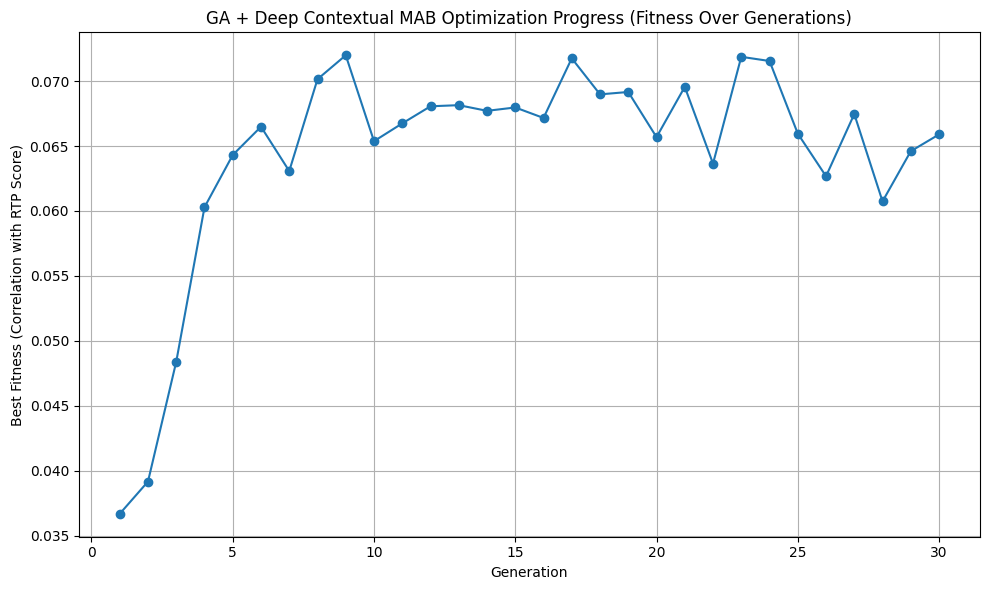

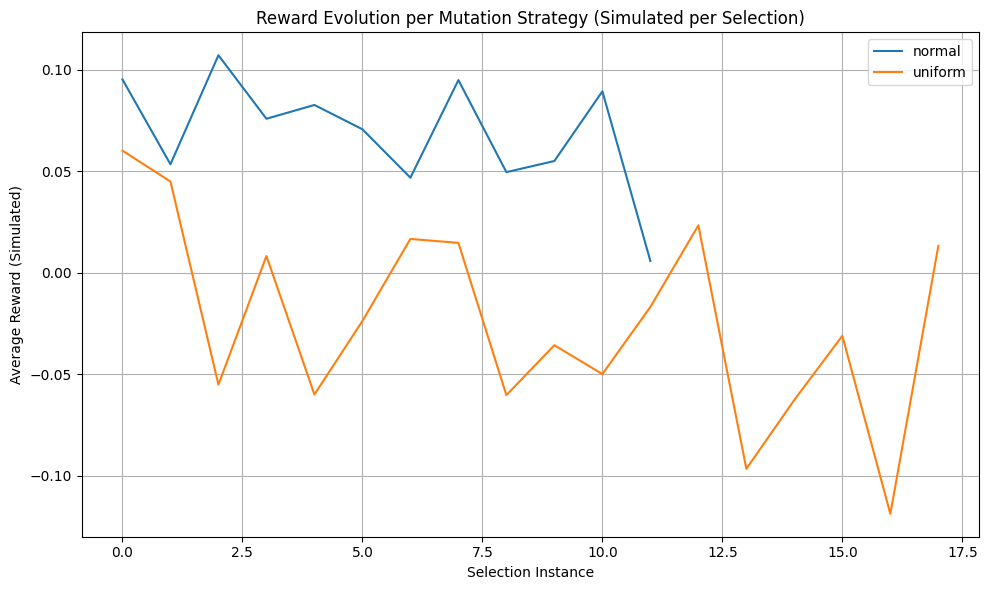

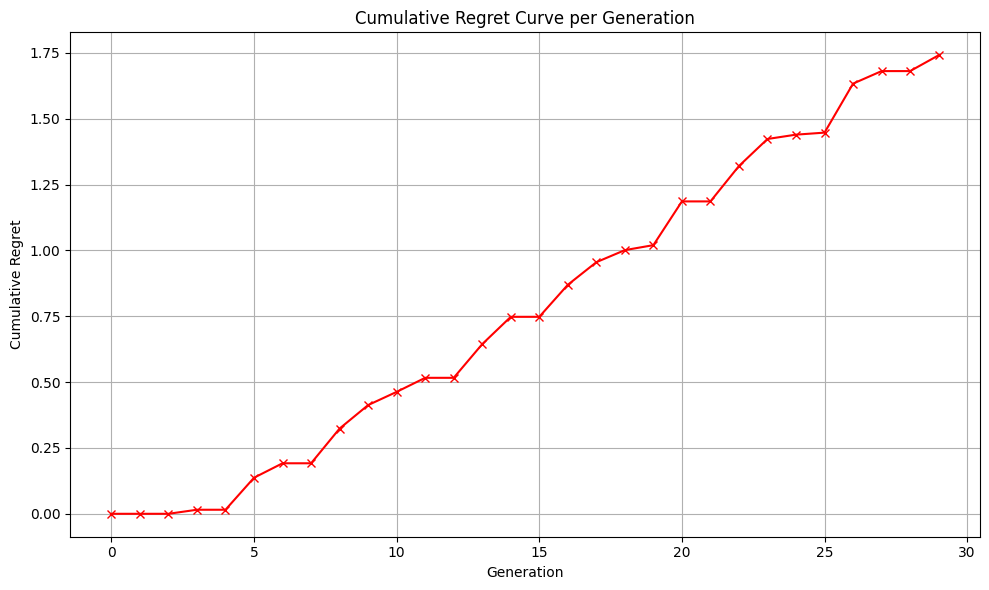

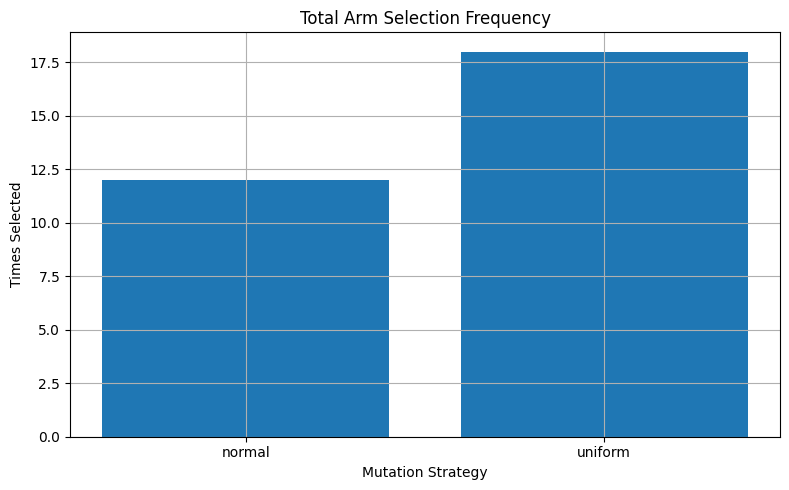

In [15]:
# Genetic Algorithm using PyGAD + RL (Deep Contextual MAB) with Balanced Exploration & Improved Regret Control
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import pygad
import random

# Load the synthetic dataset
df = pd.read_csv('/content/sample_data/synthetic_data.csv')

strategy_features = [col for col in df.columns if col != 'RTP_Score']
scaler = MinMaxScaler()
df[strategy_features] = scaler.fit_transform(df[strategy_features])

def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weighted_sum = df[strategy_features].values.dot(weights)
    simulated_rtp = np.corrcoef(weighted_sum, df['RTP_Score'])[0, 1]
    return simulated_rtp if not np.isnan(simulated_rtp) else 0

class DeepCMABAgent:
    def __init__(self, num_arms, context_dim):
        self.models = [self._build_model(context_dim) for _ in range(num_arms)]
        self.contexts = [[] for _ in range(num_arms)]
        self.rewards = [[] for _ in range(num_arms)]
        self.num_arms = num_arms
        self.context_dim = context_dim
        self.reward_history = [[] for _ in range(num_arms)]
        self.selection_counts = [0] * num_arms
        self.cumulative_rewards = [0.0] * num_arms
        self.total_selections = 0

    def _build_model(self, input_dim):
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(8, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
        return model

    def select_arm(self, context):
        self.total_selections += 1
        if min(self.selection_counts) < 3:
            # Ensure every arm gets at least 3 selections early
            return self.selection_counts.index(min(self.selection_counts))
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        preds = np.array([model.predict(context.reshape(1, -1), verbose=0)[0][0] for model in self.models])
        probs = np.exp(preds) / np.sum(np.exp(preds))
        return np.random.choice(range(self.num_arms), p=probs)

    def update(self, arm, context, reward):
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        self.contexts[arm].append(context)
        self.rewards[arm].append(reward)
        self.reward_history[arm].append(reward)
        self.selection_counts[arm] += 1
        self.cumulative_rewards[arm] += reward
        if len(self.contexts[arm]) >= self.context_dim:
            X = np.array(self.contexts[arm])
            y = np.array(self.rewards[arm])
            self.models[arm].fit(X, y, epochs=5, verbose=0)

def normal_mutation(solution, mutation_rate=0.2):
    return np.clip([gene + np.random.normal(0, 0.1) if random.random() < mutation_rate else gene for gene in solution], 0, 1)

def uniform_mutation(solution, mutation_rate=0.2):
    return np.clip([np.random.rand() if random.random() < mutation_rate else gene for gene in solution], 0, 1)

# Main Loop
generations = 30
population_size = 20
num_parents = 10
chromosome_length = len(strategy_features)
mutation_strategies = ['normal', 'uniform']
mutation_functions = [normal_mutation, uniform_mutation]
agent = DeepCMABAgent(num_arms=len(mutation_strategies), context_dim=3)
best_fitness_over_time, regret_history = [], []
cumulative_regret = 0

population = [np.random.rand(chromosome_length) for _ in range(population_size)]

for gen in range(generations):
    fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(population)]
    best_fitness = max(fitnesses)
    avg_fitness = np.mean(fitnesses)
    diversity = np.std(fitnesses)
    best_fitness_over_time.append(best_fitness)

    context = np.array([avg_fitness, best_fitness, diversity])
    selected_arm = agent.select_arm(context)
    mutation_func = mutation_functions[selected_arm]
    parents = np.array(population)[np.argsort(fitnesses)][-num_parents:]

    new_population = []
    for _ in range(population_size):
        p1, p2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, chromosome_length - 1)
        child = np.concatenate([p1[:crossover_point], p2[crossover_point:]])
        child = mutation_func(child)
        new_population.append(np.clip(child, 0, 1))

    new_fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(new_population)]
    reward = np.tanh((np.mean(new_fitnesses) - avg_fitness) * 10)
    regret = max(0, best_fitness - reward)
    cumulative_regret += regret
    regret_history.append(cumulative_regret)
    agent.update(selected_arm, context, reward)
    population = new_population

# Visualizations
plt.figure(figsize=(10, 6))
plt.plot(range(1, generations + 1), best_fitness_over_time, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Correlation with RTP Score)")
plt.title("GA + Deep Contextual MAB Optimization Progress (Fitness Over Generations)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i, strategy in enumerate(mutation_strategies):
    plt.plot(agent.reward_history[i], label=strategy)
plt.title("Reward Evolution per Mutation Strategy (Simulated per Selection)")
plt.xlabel("Selection Instance")
plt.ylabel("Average Reward (Simulated)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(regret_history, marker='x', color='red')
plt.title("Cumulative Regret Curve per Generation")
plt.xlabel("Generation")
plt.ylabel("Cumulative Regret")
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional Arm Exploration Visualization
plt.figure(figsize=(8, 5))
plt.bar(mutation_strategies, agent.selection_counts)
plt.title("Total Arm Selection Frequency")
plt.xlabel("Mutation Strategy")
plt.ylabel("Times Selected")
plt.grid(True)
plt.tight_layout()
plt.show()


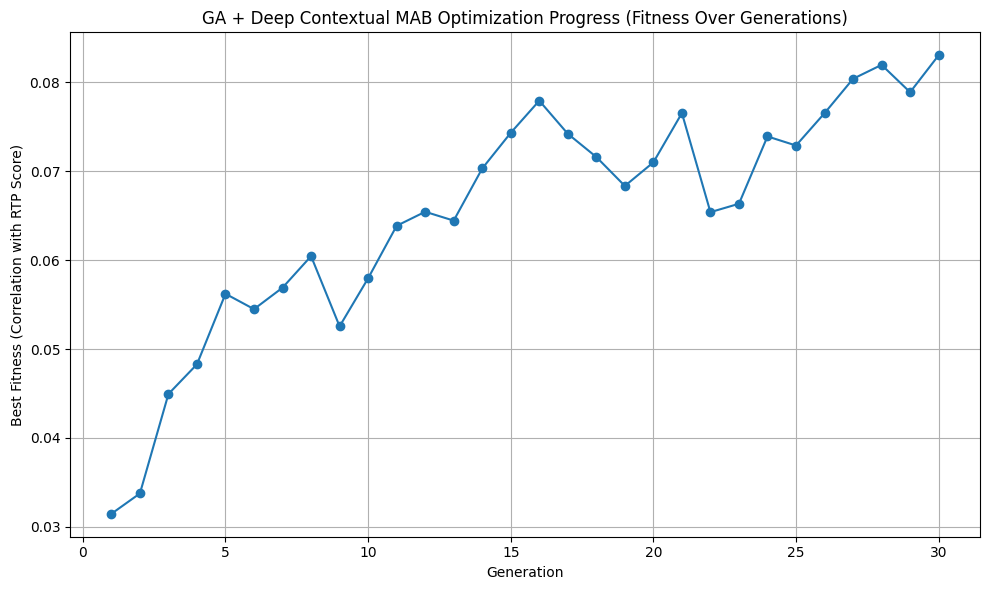

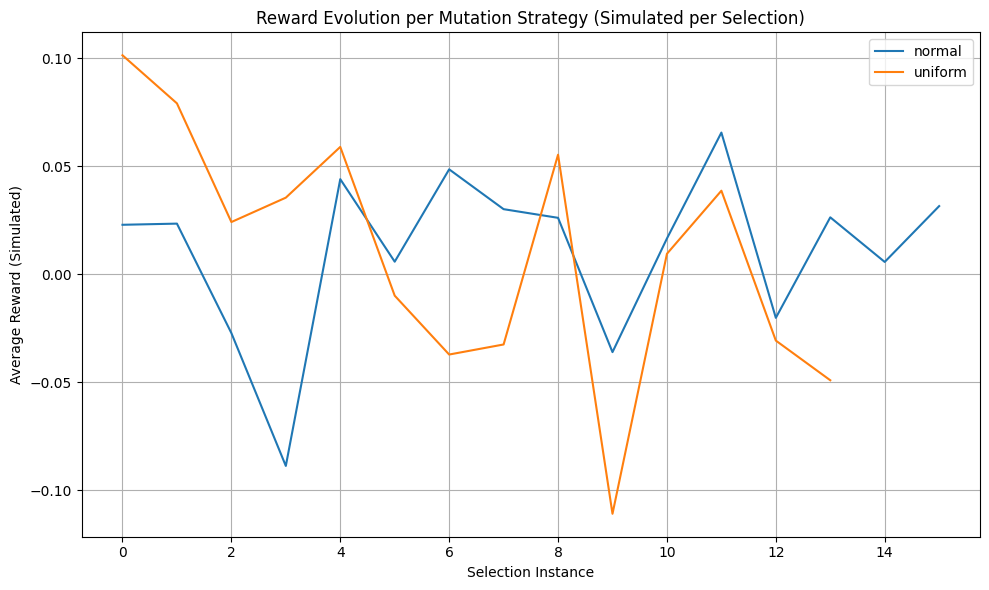

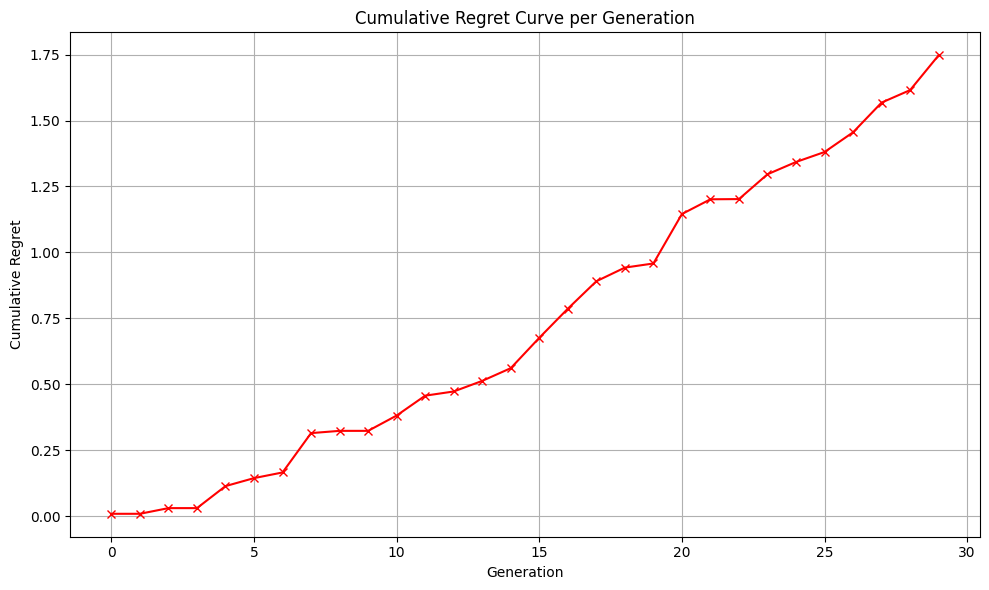

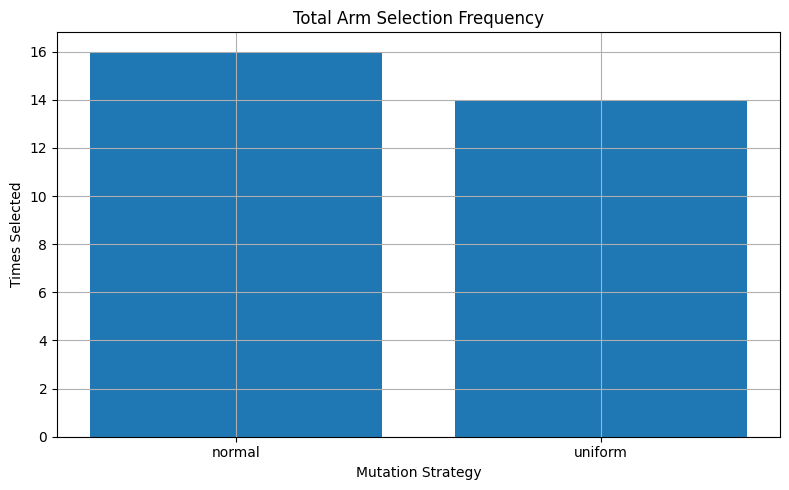

In [18]:
# Genetic Algorithm using PyGAD + RL (Deep Contextual MAB) with Balanced Exploration, Reward Penalty & Improved Regret Control
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import pygad
import random

# Load the synthetic dataset
df = pd.read_csv('/content/sample_data/synthetic_data.csv')

strategy_features = [col for col in df.columns if col != 'RTP_Score']
scaler = MinMaxScaler()
df[strategy_features] = scaler.fit_transform(df[strategy_features])

def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weighted_sum = df[strategy_features].values.dot(weights)
    simulated_rtp = np.corrcoef(weighted_sum, df['RTP_Score'])[0, 1]
    return simulated_rtp if not np.isnan(simulated_rtp) else 0

class DeepCMABAgent:
    def __init__(self, num_arms, context_dim):
        self.models = [self._build_model(context_dim) for _ in range(num_arms)]
        self.contexts = [[] for _ in range(num_arms)]
        self.rewards = [[] for _ in range(num_arms)]
        self.num_arms = num_arms
        self.context_dim = context_dim
        self.reward_history = [[] for _ in range(num_arms)]
        self.selection_counts = [0] * num_arms
        self.cumulative_rewards = [0.0] * num_arms
        self.total_selections = 0

    def _build_model(self, input_dim):
        lr = 0.01 * (0.99 ** self.total_selections if hasattr(self, 'total_selections') else 1)
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(8, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=max(lr, 0.0001)), loss='mse')
        return model

    def select_arm(self, context):
        self.total_selections += 1
        if min(self.selection_counts) < 3:
            return self.selection_counts.index(min(self.selection_counts))
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        preds = np.array([model.predict(context.reshape(1, -1), verbose=0)[0][0] for model in self.models])
        probs = np.exp(preds) / np.sum(np.exp(preds))
        return np.random.choice(range(self.num_arms), p=probs)

    def update(self, arm, context, reward):
        context = (context - np.mean(context)) / (np.std(context) + 1e-5)
        self.contexts[arm].append(context)
        self.rewards[arm].append(reward)
        self.reward_history[arm].append(reward)
        self.selection_counts[arm] += 1
        self.cumulative_rewards[arm] += reward
        if len(self.contexts[arm]) >= self.context_dim:
            X = np.array(self.contexts[arm])
            y = np.array(self.rewards[arm])
            self.models[arm].fit(X, y, epochs=5, verbose=0)

def normal_mutation(solution, mutation_rate=0.2):
    return np.clip([gene + np.random.normal(0, 0.1) if random.random() < mutation_rate else gene for gene in solution], 0, 1)

def uniform_mutation(solution, mutation_rate=0.2):
    return np.clip([np.random.rand() if random.random() < mutation_rate else gene for gene in solution], 0, 1)

# Main Loop
generations = 30
population_size = 20
num_parents = 10
chromosome_length = len(strategy_features)
mutation_strategies = ['normal', 'uniform']
mutation_functions = [normal_mutation, uniform_mutation]
agent = DeepCMABAgent(num_arms=len(mutation_strategies), context_dim=3)
best_fitness_over_time, regret_history = [], []
cumulative_regret = 0

population = [np.random.rand(chromosome_length) for _ in range(population_size)]

for gen in range(generations):
    fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(population)]
    best_fitness = max(fitnesses)
    avg_fitness = np.mean(fitnesses)
    diversity = np.std(fitnesses)
    best_fitness_over_time.append(best_fitness)

    context = np.array([avg_fitness, best_fitness, diversity])
    selected_arm = agent.select_arm(context)
    mutation_func = mutation_functions[selected_arm]
    parents = np.array(population)[np.argsort(fitnesses)][-num_parents:]

    new_population = []
    for _ in range(population_size):
        p1, p2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, chromosome_length - 1)
        child = np.concatenate([p1[:crossover_point], p2[crossover_point:]])
        child = mutation_func(child)
        new_population.append(np.clip(child, 0, 1))

    new_fitnesses = [fitness_func(None, ch, i) for i, ch in enumerate(new_population)]
    reward = np.tanh((max(new_fitnesses) - best_fitness) * 10)
    # Apply penalty if chosen arm is not most rewarding so far
    if selected_arm != np.argmax(agent.cumulative_rewards):
        reward -= 0.01
    regret = max(0, best_fitness - reward)
    cumulative_regret += regret
    regret_history.append(cumulative_regret)
    agent.update(selected_arm, context, reward)
    population = new_population

# Visualizations
plt.figure(figsize=(10, 6))
plt.plot(range(1, generations + 1), best_fitness_over_time, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Correlation with RTP Score)")
plt.title("GA + Deep Contextual MAB Optimization Progress (Fitness Over Generations)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i, strategy in enumerate(mutation_strategies):
    plt.plot(agent.reward_history[i], label=strategy)
plt.title("Reward Evolution per Mutation Strategy (Simulated per Selection)")
plt.xlabel("Selection Instance")
plt.ylabel("Average Reward (Simulated)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(regret_history, marker='x', color='red')
plt.title("Cumulative Regret Curve per Generation")
plt.xlabel("Generation")
plt.ylabel("Cumulative Regret")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(mutation_strategies, agent.selection_counts)
plt.title("Total Arm Selection Frequency")
plt.xlabel("Mutation Strategy")
plt.ylabel("Times Selected")
plt.grid(True)
plt.tight_layout()
plt.show()
